In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
df_gscore = pd.read_csv('genome-scores.csv')
df_gtags = pd.read_csv('genome-tags.csv')
df_links = pd.read_csv('links.csv')
df_movies = pd.read_csv('movies.csv')
df_rating = pd.read_csv('ratings.csv')
df_tagspd = pd.read_csv('tags.csv')

## Creating the genome dataset

In [2]:
df_gtagscore=df_gtags.merge(df_gscore, how='right', on='tagId').drop('tag', axis =1)
df_gtagscore.drop_duplicates(subset=['tagId', 'movieId'],inplace=True)
df_gtagscore.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   tagId      11709768 non-null  int64  
 1   movieId    11709768 non-null  int64  
 2   relevance  11709768 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 357.4 MB


# pivoting the datafram

In [3]:
df_gtagscore = df_gtagscore.pivot(index = 'movieId', columns = 'tagId', values='relevance')

In [7]:
df_gtagscore.shape

(10381, 1128)

# Feature reduction with PCA

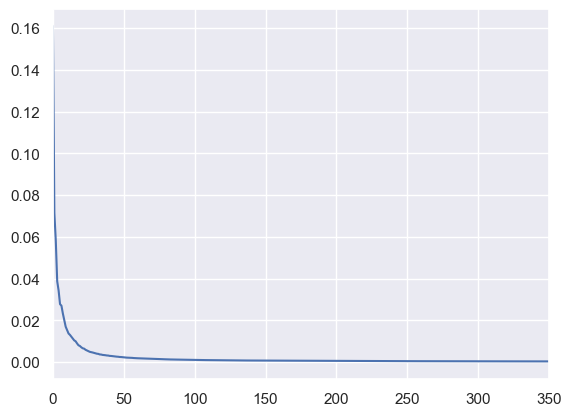

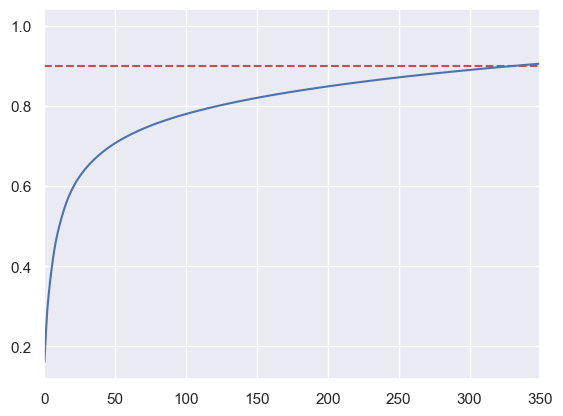

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca =PCA()
data_2D=pca.fit_transform(df_gtagscore)

plt.figure()
plt.xlim(0,350)
plt.plot(pca.explained_variance_ratio_);

plt.figure()
plt.xlim(0,350)
plt.axhline(y = 0.9, color ='r', linestyle = '--')
plt.plot(pca.explained_variance_ratio_.cumsum());

In [5]:
pca = PCA(n_components=0.9)
pca.fit_transform(df_gtagscore)
pca.n_components_

331

# testing the reduced dataset with a target value

adding genre as target value

In [6]:
df_movies = pd.read_csv('movies.csv')
df_movies.genres= df_movies.genres.str.split('|')
dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)
df_movies = pd.concat([df_movies, dummies], axis=1).drop(['genres','title'], axis=1)


C:\Users\HamidEsfahlani\AppData\Local\Temp\ipykernel_20200\1376084897.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)


In [31]:
df = df_movies[['movieId', 'Drama']]
df['target'] = df[['Drama']].apply(lambda row: 1 if row.any() else 0, axis=1)
df=df.drop(['Drama'], axis =1)
df.target.value_counts(normalize=True)

C:\Users\HamidEsfahlani\AppData\Local\Temp\ipykernel_20200\1932699825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df[['Drama']].apply(lambda row: 1 if row.any() else 0, axis=1)


0    0.510815
1    0.489185
Name: target, dtype: float64

merging and spliting the datasets into train and test sets

In [32]:
df_withTarget=pd.merge(df_gtagscore,df, how='inner', on='movieId')
target =  df_withTarget.target
data= df_withTarget.drop(['movieId','target'], axis =1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,target,test_size = .2)

training the PCA and reducing features

In [34]:
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

testing the score

In [35]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs = -1)
clf.fit(X_train_pca, y_train)
print('Score with reduced dataset:', clf.score(X_test_pca, y_test))
clf02 = RandomForestClassifier(n_jobs = -1)
clf02.fit(X_train, y_train)
print('Score with original dataset:', clf02.score(X_test, y_test))

Score with reduced dataset: 0.8252286952335098
Score with original dataset: 0.8343765045739047


In [36]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train_pca, y_train)
print('Score with reduced dataset:', svc.score(X_test_pca, y_test))
svc02 = SVC()
svc02.fit(X_train, y_train)
print('Score with original dataset:', svc02.score(X_test, y_test))

Score with reduced dataset: 0.8560423688011555
Score with original dataset: 0.8531535869041887


In [37]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train_pca, y_train)
print('Score with reduced dataset:', KNN.score(X_test_pca, y_test))
KNN02 = KNeighborsClassifier(n_neighbors=5)
KNN02.fit(X_train, y_train)
print('Score with original dataset:', KNN02.score(X_test, y_test))

Score with reduced dataset: 0.8050072219547424
Score with original dataset: 0.8069330765527203


## adding realease year and genres as columns

In [16]:
df_movies = pd.read_csv('movies.csv')
mask = df_movies['title'].str.contains('09–')

df_movies = pd.read_csv('movies.csv')
def condition(x):
    if x[-2:]=='a)':
        return np.nan
    elif x[-2:]=='l)':
        return np.nan
    elif x[-3:-1]=='7-':
        return 2007
    elif x[-4:-2]=='9–':
        return 2009
    elif x[-2:]=='))':
        return x[-6:-2]
    elif x[-1:]==')':
        return x[-5:-1]
    elif x[-1:]==' ':
        return x[-6:-2]
    else:
        return np.nan
df_movies['releaseyear'] = df_movies['title'].apply(condition)

In [17]:
df_movies.genres= df_movies.genres.str.split('|')
dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)
df_movies = pd.concat([df_movies, dummies], axis=1).drop('genres', axis=1)

C:\Users\HamidEsfahlani\AppData\Local\Temp\ipykernel_8212\1447042938.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  dummies = pd.get_dummies(df_movies.genres.apply(pd.Series).stack()).sum(level=0)


In [18]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
df_movies.drop('title', axis =1)
"""
le = LabelEncoder()
le.fit(df_movies.genres)
df_movies.genres= le.transform(df_movies.genres)

scaler = MinMaxScaler()
df_movies.genres = scaler.fit_transform(df_movies[['genres']])
"""
scaler02 = MinMaxScaler()
df_movies.releaseyear = scaler02.fit_transform(df_movies[['releaseyear']])

df_movies.describe()

,movieId,releaseyear,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,27278.000000,27259.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,...,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000,27278.000000
mean,59855.480570,0.793327,0.009018,0.129042,0.085380,0.037649,0.041755,0.306987,0.107743,0.090586,...,0.012098,0.095718,0.007185,0.037979,0.055503,0.151294,0.063898,0.153164,0.043772,0.024782
std,44429.314697,0.188185,0.094537,0.335252,0.279452,0.190350,0.200033,0.461253,0.310061,0.287024,...,0.109324,0.294210,0.084462,0.191150,0.228963,0.358342,0.244575,0.360152,0.204590,0.155463
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6931.250000,0.685484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68068.000000,0.862903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100293.250000,0.943548,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131262.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
df_ContBaseRec = pd.merge(df_gtagscore, df_movies, how='inner', on='movieId').set_index('movieId')
df_ContBaseRec.describe()

,1,2,3,4,5,6,7,8,9,10,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,...,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000,10381.000000
mean,0.045935,0.045552,0.069405,0.085837,0.137502,0.091156,0.061408,0.159705,0.111614,0.068471,...,0.010789,0.098738,0.015798,0.038628,0.059243,0.168963,0.087564,0.193623,0.042385,0.021096
std,0.070003,0.061164,0.108857,0.091188,0.148044,0.098205,0.085536,0.129250,0.140207,0.094508,...,0.103313,0.298324,0.124700,0.192717,0.236090,0.374737,0.282673,0.395156,0.201476,0.143712
min,0.005750,0.007250,0.006000,0.010750,0.016750,0.005500,0.004750,0.011500,0.001750,0.008000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.026250,0.027750,0.024750,0.037250,0.062000,0.034750,0.019750,0.070500,0.033750,0.024250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.034250,0.036500,0.035500,0.051250,0.087000,0.059250,0.032500,0.115750,0.059500,0.035000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.045750,0.049750,0.065750,0.097750,0.143000,0.106750,0.067000,0.208000,0.127750,0.070250,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.999750,1.000000,0.998000,0.928750,0.981500,0.931500,0.949750,0.874500,0.993000,0.926250,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df_ContBaseRec.head()

,1,2,3,4,5,6,7,8,9,10,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,...,0,0,0,0,0,0,0,0,0,0
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,...,0,0,0,0,0,0,0,0,0,0
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,...,0,0,0,0,0,1,0,0,0,0
4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,0.03025,...,0,0,0,0,0,1,0,0,0,0
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,...,0,0,0,0,0,0,0,0,0,0
